In [30]:
%load_ext autoreload
%autoreload 2

from tweedejaars_project import *
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import *
from sklearn.preprocessing import *
from sklearn.compose import *
from sklearn.kernel_approximation import *
from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.neural_network import *
from sklearn.linear_model import *
import xgboost as xgb
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, MissingIndicator
from statsmodels.tsa.statespace.sarimax import SARIMAX

# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'


df = load_df()


def to_category(df: pd.DataFrame, feature: str):
    df[feature] = df[feature].astype("category")
    return df


def to_bool(df: pd.DataFrame, feature: str):
    df[feature] = df[feature].astype(bool)
    return df


def recast_categorical(df: pd.DataFrame, to_cat=True):
    features = [
        "naive_strategy_action",
        "workday",
        "is_balanced"
    ]
    
    func = to_category if to_cat else to_bool
    for feature in features:
        df = func(df, feature)
    return df


def lag_df(df: pd.DataFrame):
    features = {
        "min_price_published": [1],
        "max_price_published": [1],
        "fix_two_sided_ptu_alt": [17],
        "settlement_price_realized": [17],
        "minute_in_ptu": [2]
        
    }
    lagged_features = []
    for feature, amounts in features.items():
        for amount in amounts:
            df = lag(df, feature, amount)
            lagged_features.append(df.columns[-1])
    return df, lagged_features

# df = recast_categorical(df)

df, lagged_features = lag_df(df)

def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )


version = "target"
target = "fix_two_sided_ptu_alt"
train_set = "train"
test_set = "valid"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


count    16.000000
mean      0.028498
std       0.003327
min       0.023346
25%       0.025851
50%       0.028630
75%       0.031698
max       0.035070
Name: 0, dtype: float64
0.035069639899929804


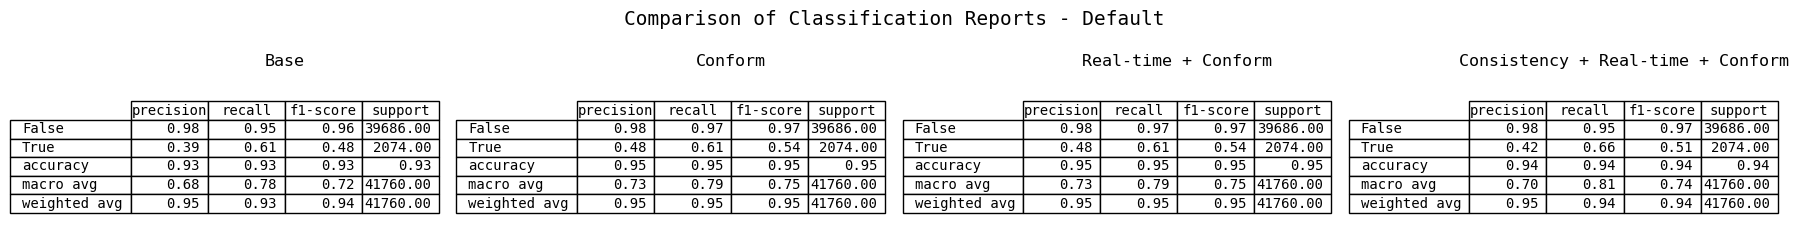

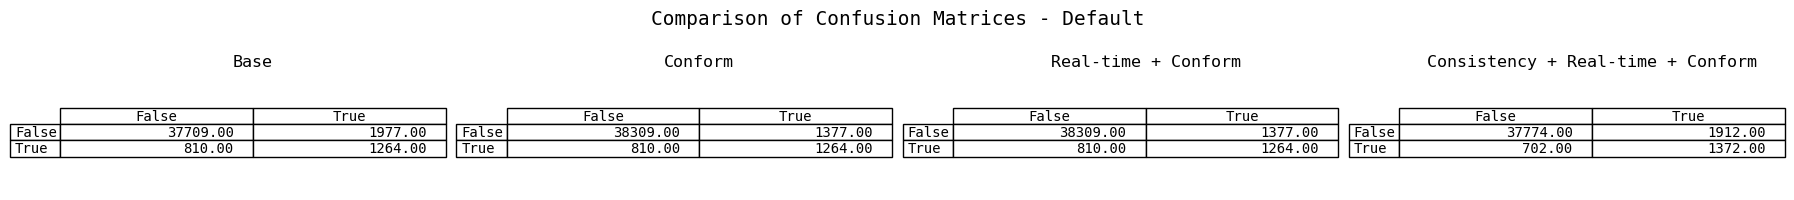

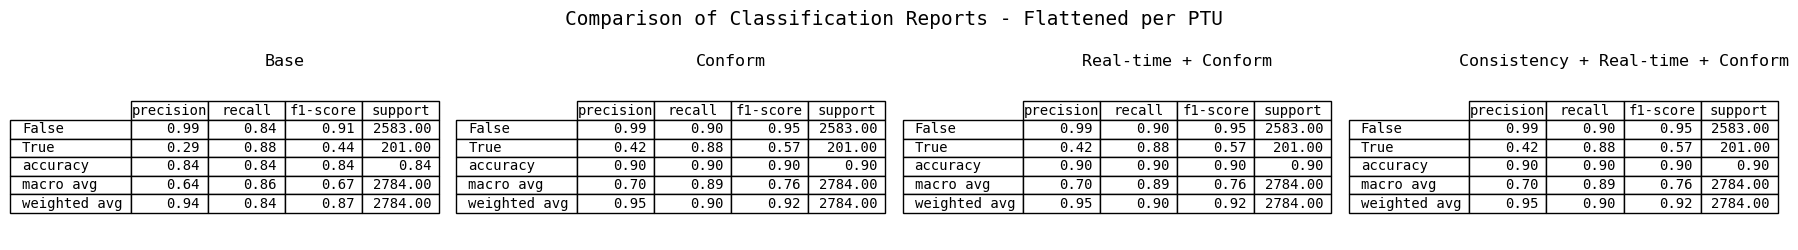

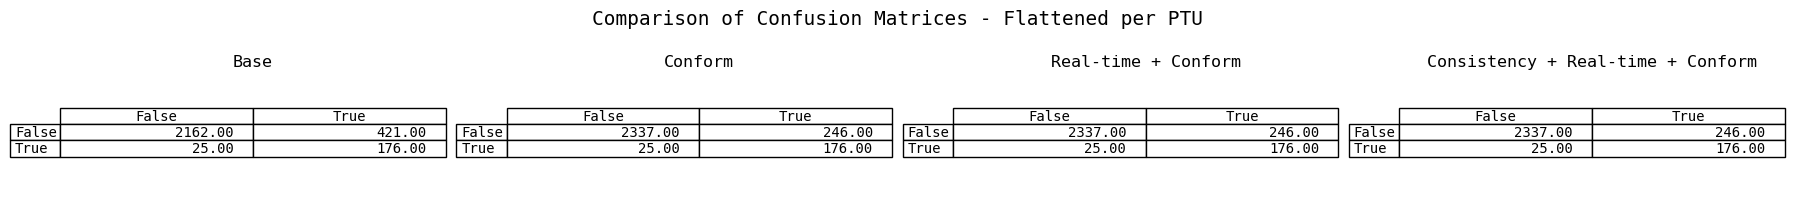

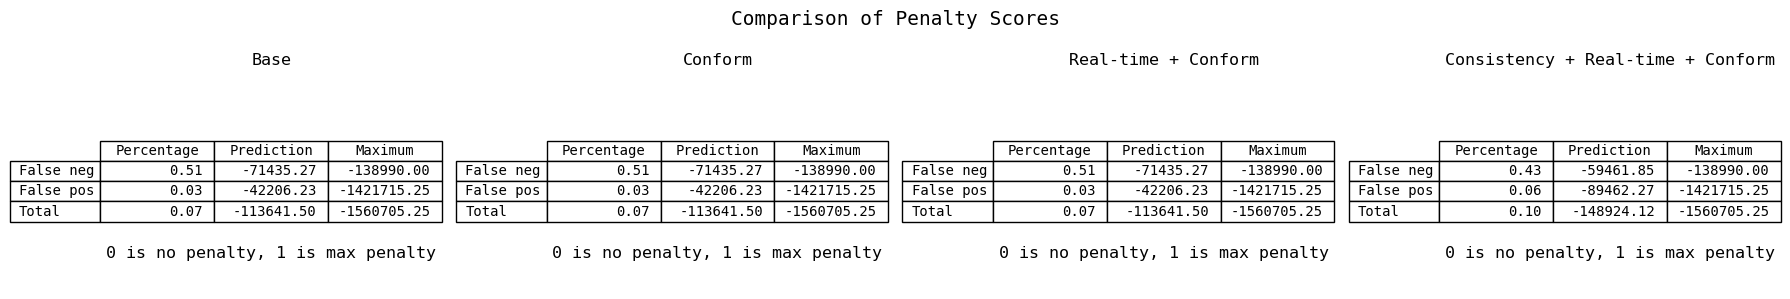

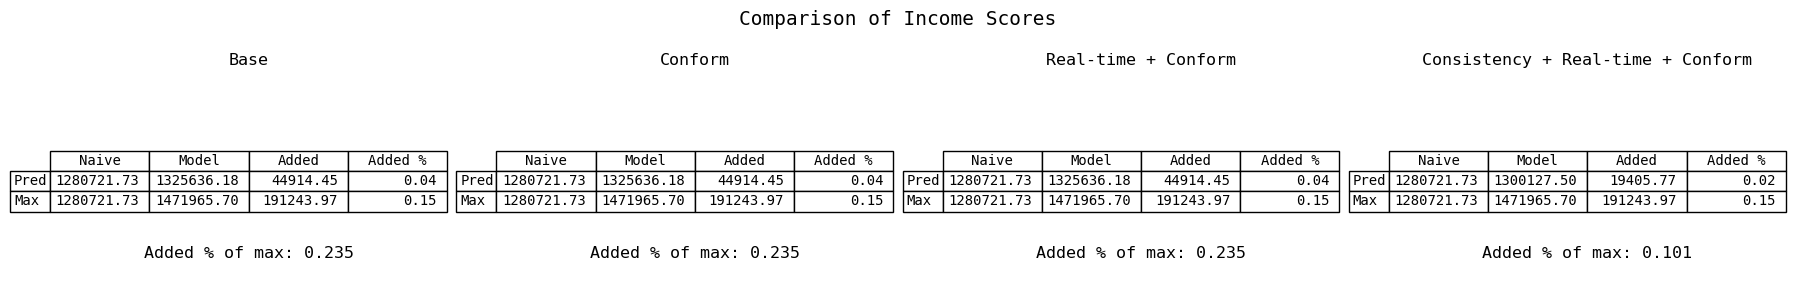

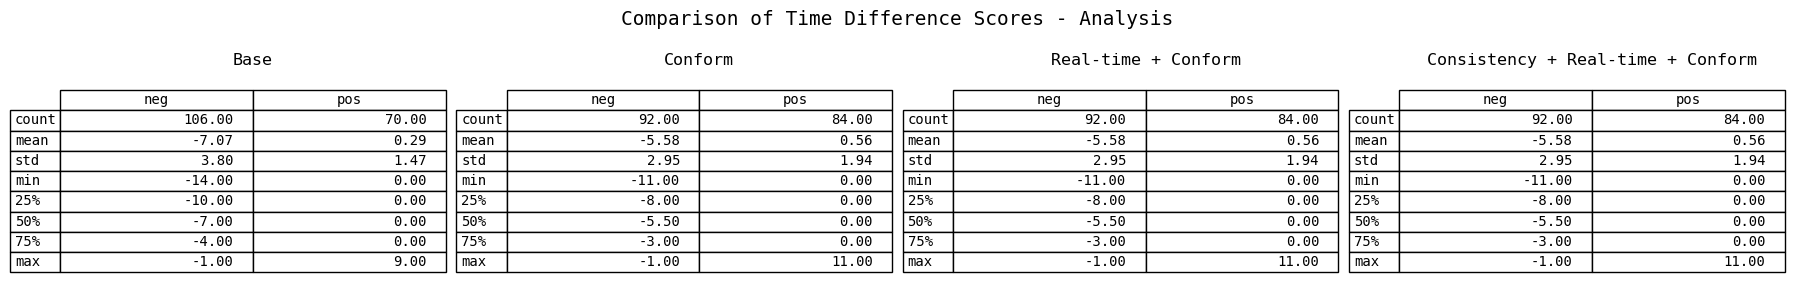

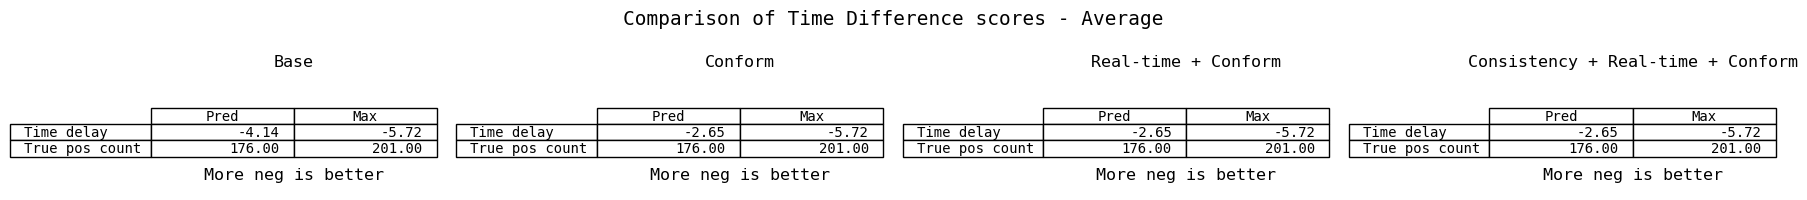

In [31]:
features = [
    "import_capacity",
    "min_price_published",
    "mid_price_published",
    "max_price_published",
    "min_ptu_price_known",
    "max_ptu_price_known",
    # "upward_dispatch_published",
    # "downward_dispatch_published",
    # "igcc_contribution_up_published",
    # "igcc_contribution_down_published",
    "time_since_last_two_sided",
    "two_sided_daily_count",
    "PTU",
    "minute_in_ptu",
    "naive_strategy_action",
    "vwap_avg",
    "vwap_std",
    "vwap_median",
    "vwap_qty_sum",
    "hvq_delta",
    # "forecast_wind",
    # "forecast_solar",
    # "forecast_demand",
    # "fix_two_sided_ptu_realtime",
    "residual_load",
    "dispatch_diff",
    "igcc_diff",
    "is_balanced",
    "weekday",
    "workday",
    # "hour",
    "month",
    # "day",
    # "minute",
    "down_negative",
    "down_price_volume",
    "up_price_volume",
    "diff_price_volume"
] + lagged_features
splits = get_splits(df, features, target, return_dict_pair=False)


def train(train_in, train_out):
    # categorical_columns = train_in.columns[train_in.dtypes == "category"]
    # one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    # cyclic_spline_transformer = ColumnTransformer(
    #     transformers=[
    #         ("categorical", one_hot_encoder, categorical_columns),
    #         ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3), ["weekday"]),
    #         # ("cyclic_hour", periodic_spline_transformer(24, n_splines=12), ["hour"]),
    #         ("cyclic_PTU", periodic_spline_transformer(96, n_splines=48), ["PTU"]),
    #         ("cyclic_minute_in_ptu", periodic_spline_transformer(15, n_splines=7), ["minute_in_ptu"]),
    #     ],
    #     remainder=MinMaxScaler(),
    #     n_jobs=-1
    # )
    # model = make_pipeline(
    #     cyclic_spline_transformer,
    #     # SimpleImputer(),
    #     # Nystroem(kernel="poly", degree=2, n_components=300, random_state=0, n_jobs=-1),
    #     # RidgeClassifierCV(),
    #     # HistGradientBoostingRegressor(loss="poisson", l2_regularization=8, learning_rate=0.05, validation_fraction=0.5, categorical_features="from_dtype"),
    #     memory="cache/test3"
    # )
    # model = make_pipeline(
    #     # transformer,
    #     # IterativeImputer(sample_posterior=True, initial_strategy="mean", max_iter=100, skip_complete=True, add_indicator=True),
    #     MinMaxScaler(),
    #     SimpleImputer(),
    #     RidgeCV()
    #     # HistGradientBoostingRegressor(loss="poisson", l2_regularization=4, learning_rate=0.3, validation_fraction=0.2)
    #     # ExtraTreesRegressor(n_jobs=-1)
    # )
    model = HistGradientBoostingRegressor(loss="poisson", l2_regularization=8, learning_rate=0.05, validation_fraction=0.5, categorical_features="from_dtype")
    # model = xgb.XGBClassifier(objective="binary:hinge", subsample=0.9, tree_method="hist", grow_policy="lossguide", max_depth=8)
    # model = HistGradientBoostingClassifier(l2_regularization=8, learning_rate=0.3, validation_fraction=0.2, class_weight={0:1, 1:4})
    # model = SARIMAX(train_out, exog=train_in, order=(5, 1, 0))
    # model = RandomForestRegressor(n_estimators=200, criterion="poisson", max_features="log2", n_jobs=-1)
    # model = RandomForestClassifier(n_estimators=200, criterion="log_loss", max_features="log2", class_weight="balanced", n_jobs=-1)

    model = model.fit(train_in, train_out)
    
    return model


def test(model, test_in):
    # pred = model.forecast(steps=len(test_in), exog=test_in)
    pred = model.predict(test_in)
    return recast_pred(pred > 0.5)


# splits[train_set][3]["neg"] = splits[train_set][3]["min_price_published"] < 0
# mask = splits[train_set][3].groupby("ptu_id")["neg"].transform("any")
# mask = splits[train_set][3].groupby("ptu_id")["naive_strategy_action"].transform("any")
# mask = mask | splits[train_set][3]["fix_two_sided_ptu"]
# mask = splits[train_set][3]["naive_strategy_action"] | splits[train_set][3]["fix_two_sided_ptu"]


# def upsample(train_in, train_out, factor=1):
#     sample_in = train_in[train_out]
#     sample_out = train_out[train_out]
#     for _ in range(factor):
#         train_in = pd.concat([train_in, sample_in])
#         train_out = pd.concat([train_out, sample_out])
#     return train_in, train_out

# splits[train_set][0], splits[train_set][1] = upsample(splits[train_set][0], splits[train_set][1])

# splits[test_set][3] = recast_categorical(splits[test_set][3], False)

best, _ = evaluate_income(train, test, splits[train_set][0], splits[train_set][1], splits[test_set][0], splits[test_set][3], repeat=16)

print(best[1])
p1 = test(best[0], splits[test_set][0])
show_metrics_adjusted(splits[test_set][3], p1, version=version)

# TODO
# Make target the penalty
# Use the 2 min delay
# price realized use
# Use ransac or something to better fit the minute in ptu
# Drop cutoff ptus
# Cache penalties
# Fix naive strategy action
# Fix pred fix max
# ...

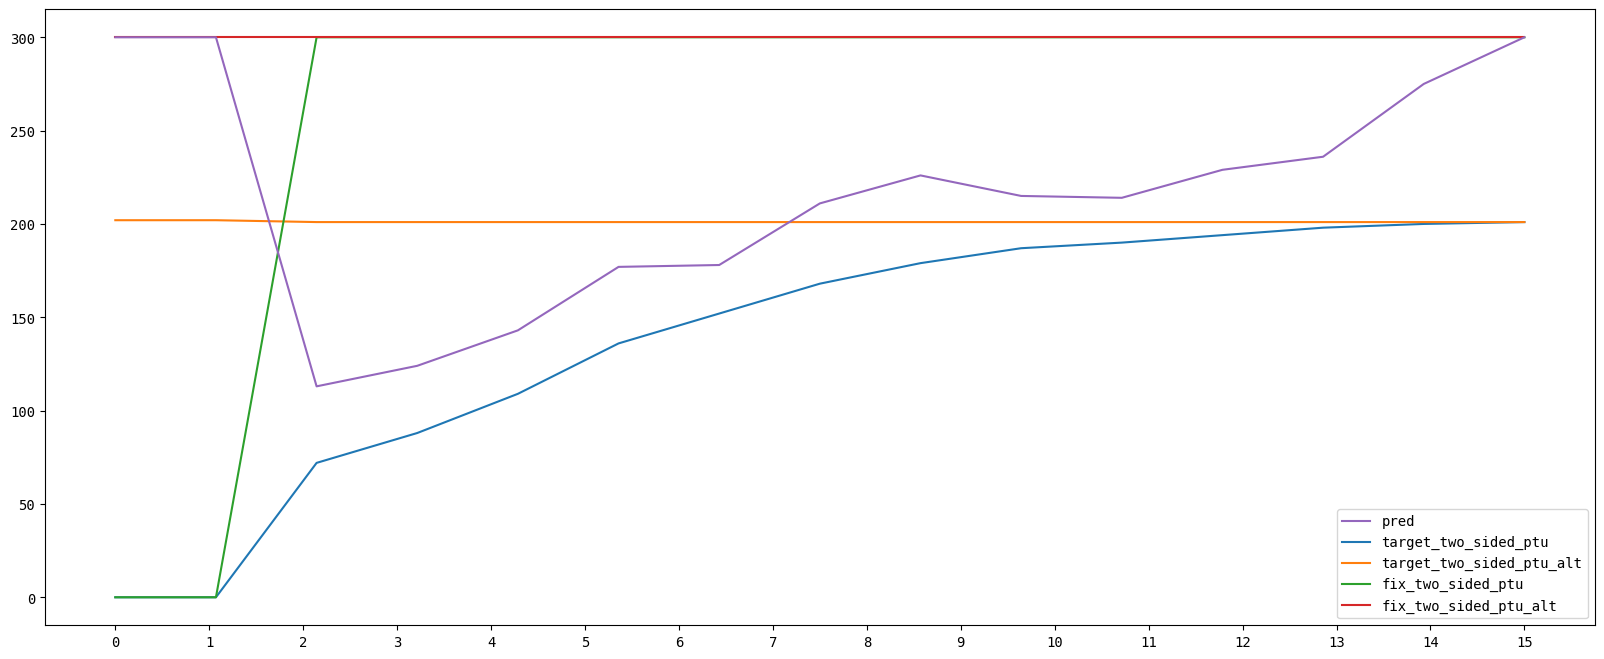

In [32]:
targets = [
    "target_two_sided_ptu",
    "target_two_sided_ptu_alt",
    # "target_two_sided_ptu_realtime",
    "fix_two_sided_ptu",
    "fix_two_sided_ptu_alt",
    # "fix_two_sided_ptu_realtime",
    "pred"
]
agg_dict = {t: "sum" for t in targets}
view = splits[test_set][3]
view["pred"] = p1
items = 15
flat_df = view.groupby("minute_in_ptu").agg(agg_dict)
flat_df.index = np.linspace(0, items, items)

for t in targets:
    plot_against_index(flat_df[t], show=False)
plt.xticks(range(0, items + 1, 1))
show_graph()